# Origin of Tourists

**Objective Sprint 4**  
Adjust offers to the `traveler's profile` and the `demand for overnight stays` in the cities where we are present, considering the official figures on origin, months of visit and average overnight stays per autonomous city.

**Description and characteristics of dataset**  
Hotel occupancy survey from the National Institute of Statistics
https://www.ine.es/dynt3/inebase/es/index.htm?padre=238&dh=1

In [1]:
# import libraries 
import os
import re
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
# font sizes
plt.rcParams['figure.titlesize'] = 18 
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['font.size'] = 14             
plt.rcParams['axes.labelsize'] = 14  

plt.rcParams['xtick.labelsize'] = 12      
plt.rcParams['ytick.labelsize'] = 12       
plt.rcParams['legend.fontsize'] = 12

# display settings
#pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', 50)
pd.set_option('display.float_format', '{:.2f}'.format)
 
# set palette
#custom_palette = ['#4e6e81', '#a79e9c', '#b3bcc3', '#f2f1f1', '#888f96', '#256fb6', '#ecf0f5', '#354859', '#f69731']
#sns.set_palette(custom_palette)
sns.set_palette('Paired')

sns.set_style("whitegrid")

## Number of turists by country of residence
Table used: [Viajeros y pernoctaciones según país de residencia del viajero](https://www.ine.es/jaxiT3/Tabla.htm?t=2038&L=0)  
Loaded data is from 03-2022 to 03-2025.

*Notes*:
    
- `resto de la UE`: Chipre, Eslovaquia, Eslovenia, Estonia, Hungría, Letonia, Lituania y Malta, Bulgaria y Rumanía
- `UE27_2020` (Unión Europea desde el 1 de febrero de 2020 ) y `UE28` (Unión Europea desde el 1 de julio de 2013 hasta el 31 de enero de 2020) hacen referencia a la situación legal de la Unión Europea en cada momento.
- Desde marzo de 2022, se incluye "Rusia" en el agregado `Resto de Europa`

- Establecimientos hoteleros: los datos de **abril del año 2024 y posteriores** son provisionales
- Debido a distintas actualizaciones en los directorios de establecimientos, no son directamente comparables los datos de distintos años. Existen coeficientes de enlace para los períodos: año 2005, junio2009-mayo2010, julio2010-febrero2012.

### Data Loading

In [3]:
# define function to read file
def read_file(filename):
    
    """Input: number of sprint.
    Function reads .csv data of desired sprint. 
    Output: Dataframe or error.
    """
    
    # reading file
    try:
        df = pd.read_csv(os.path.join('..', 'data', filename), encoding='latin1', sep=';')
        display(df.head())
        return df
    except Exception as error:
        print("An exception occurred:", error)
        return error      

In [21]:
df = read_file('INE_Encuesta_de_ocupación_hotelera_2038.csv')

,RESIDENCIA/ORIGEN,Países,Viajeros y pernoctaciones,Periodo,Total
0,Total,NaN,Viajero,2025M03,7.680.722
1,Total,NaN,Viajero,2025M02,6.539.960
2,Total,NaN,Viajero,2025M01,5.776.075
3,Total,NaN,Viajero,2024M12,6.553.489
4,Total,NaN,Viajero,2024M11,7.171.221


In [5]:
df.isna().sum()

RESIDENCIA/ORIGEN              0
Países                       370
Viajeros y pernoctaciones      0
Periodo                        0
Total                        148
dtype: int64

In [6]:
df['RESIDENCIA/ORIGEN'].unique()

array(['Total', 'América (sin EEUU)', 'Estados Unidos de América',
       'Japón', 'Asia (sin Japón)'], dtype=object)

In [7]:
df[df['RESIDENCIA/ORIGEN']=='Japón']

,RESIDENCIA/ORIGEN,Países,Viajeros y pernoctaciones,Periodo,Total
2220,Japón,NaN,Viajero,2025M03,40.196
2221,Japón,NaN,Viajero,2025M02,37.691
2222,Japón,NaN,Viajero,2025M01,28.733
2223,Japón,NaN,Viajero,2024M12,32.605
2224,Japón,NaN,Viajero,2024M11,31.239
...,...,...,...,...,...
2289,Japón,NaN,Pernoctaciones,2022M07,29.439
2290,Japón,NaN,Pernoctaciones,2022M06,24.511
2291,Japón,NaN,Pernoctaciones,2022M05,20.421
2292,Japón,NaN,Pernoctaciones,2022M04,20.113


In [8]:
df[df['RESIDENCIA/ORIGEN']=='Asia (sin Japón)']

,RESIDENCIA/ORIGEN,Países,Viajeros y pernoctaciones,Periodo,Total
2294,Asia (sin Japón),NaN,Viajero,2025M03,NaN
2295,Asia (sin Japón),NaN,Viajero,2025M02,NaN
2296,Asia (sin Japón),NaN,Viajero,2025M01,NaN
2297,Asia (sin Japón),NaN,Viajero,2024M12,NaN
2298,Asia (sin Japón),NaN,Viajero,2024M11,NaN
...,...,...,...,...,...
2363,Asia (sin Japón),NaN,Pernoctaciones,2022M07,NaN
2364,Asia (sin Japón),NaN,Pernoctaciones,2022M06,NaN
2365,Asia (sin Japón),NaN,Pernoctaciones,2022M05,NaN
2366,Asia (sin Japón),NaN,Pernoctaciones,2022M04,NaN


In [9]:
df['Países'].unique()

array([nan, 'Residentes en España', 'Residentes en el Extranjero',
       'Alemania', 'Austria', 'Bélgica', 'Dinamarca', 'Finlandia',
       'Francia', 'Grecia', 'Irlanda', 'Italia', 'Luxemburgo',
       'Países Bajos', 'Polonia', 'Portugal', 'República Checa', 'Suecia',
       'Resto de la U.E.', 'Noruega', 'Reino Unido', 'Rusia', 'Suiza',
       'Otros Países Europeos', 'África', 'UE28 sin España',
       'UE27_2020 sin España', 'Resto del Mundo'], dtype=object)

In [10]:
df[df['Total'].isna()]['Países'].value_counts()

Países
Rusia    74
Name: count, dtype: int64

In [11]:
df[df['Total'].isna()]['RESIDENCIA/ORIGEN'].value_counts()

RESIDENCIA/ORIGEN
Total               74
Asia (sin Japón)    74
Name: count, dtype: int64

### Data cleaning

In [23]:
# drop rows without stat
df = df.dropna(subset='Total')

# fill NaN in country column
df['Países'] = df['Países'].fillna(df['RESIDENCIA/ORIGEN'])

In [24]:
# 'Viajeros y pernoctaciones' to 2 different columns
df = (df.drop('RESIDENCIA/ORIGEN', axis=1)
        .pivot(index=['Países', 'Periodo'], columns='Viajeros y pernoctaciones', values='Total')
        .reset_index()
        .rename(columns={'Viajero': 'total_travelers', 'Pernoctaciones': 'total_overnight_stays'})
     )
df.columns.name = None

In [25]:
# change data types
df['Periodo'] = pd.to_datetime(df['Periodo'], format='%YM%m')
df['total_overnight_stays'] = df['total_overnight_stays'].str.replace('.', '', regex=False).astype(int)
df['total_travelers'] = df['total_travelers'].str.replace('.', '', regex=False).astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1110 entries, 0 to 1109
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Países                 1110 non-null   object        
 1   Periodo                1110 non-null   datetime64[ns]
 2   total_overnight_stays  1110 non-null   int64         
 3   total_travelers        1110 non-null   int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 34.8+ KB


In [26]:
# add column with average stay (days)
df['avg_stay'] = df['total_overnight_stays'] / df['total_travelers']

In [27]:
df_total = df[df['Países'].isin(['Residentes en España', 'Residentes en el Extranjero'])]
df = df[~df['Países'].isin(['Total', 'Residentes en España', 'Residentes en el Extranjero',
                            'UE27_2020 sin España', 'UE28 sin España'])]

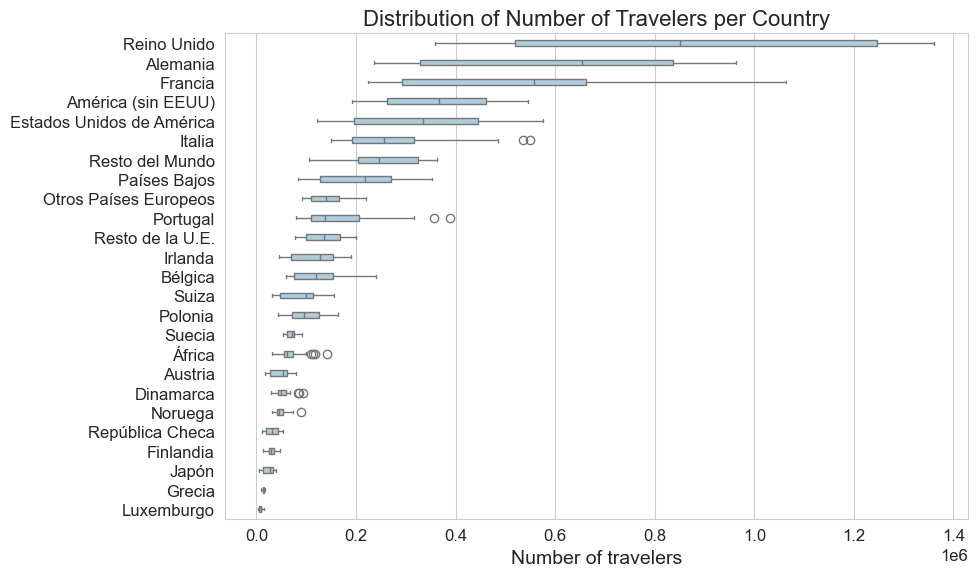

In [28]:
# boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, 
            y='Países', 
            x='total_travelers',
            width=0.3,
            order=df.groupby('Países')['total_travelers'].median().sort_values(ascending=False).index)

plt.xlabel('Number of travelers')
plt.ylabel(None)
plt.title('Distribution of Number of Travelers per Country')
plt.tight_layout()
plt.show()

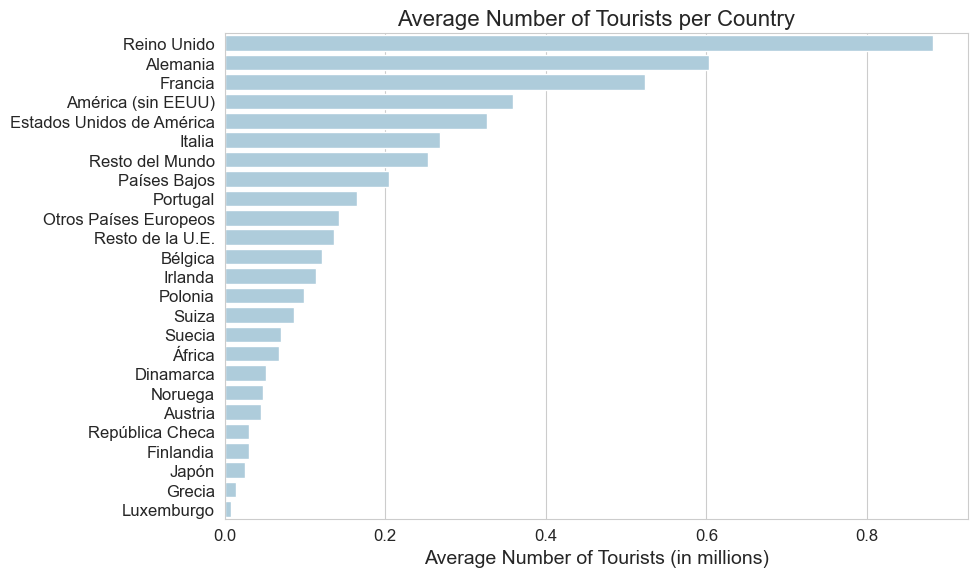

In [29]:
# means for ordering
mean_order = df.groupby('Países')['total_travelers'].mean().sort_values(ascending=False).index

# barplot 
plt.figure(figsize=(10, 6))
sns.barplot(data=df,
            y='Países',
            x=df['total_travelers'] / 1000000,
            estimator='mean',
            order=mean_order,
            errorbar=None)

plt.xlabel('Average Number of Tourists (in millions)')
plt.ylabel(None)
plt.title('Average Number of Tourists per Country')
plt.tight_layout()
plt.show()

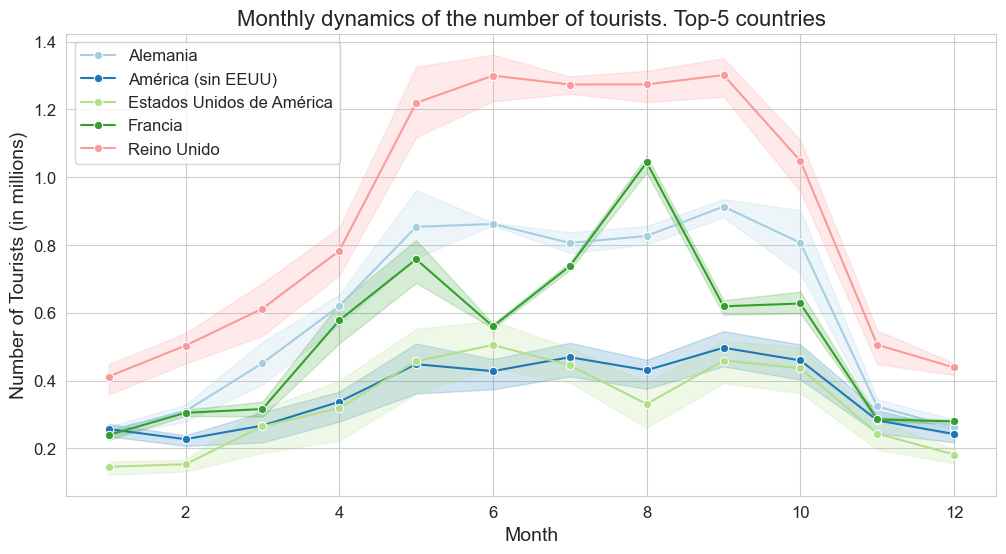

In [36]:
# top 5 countries by overall mean
top5_paises = df.groupby('Países')['total_travelers'].mean().nlargest(5).index
df_top5 = df[df['Países'].isin(top5_paises)]

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_top5, x=df['Periodo'].dt.month, y=df['total_travelers']/1000000, hue='Países', marker='o')

plt.title('Monthly dynamics of the number of tourists. Top-5 countries')
plt.xlabel('Month')
plt.ylabel('Number of Tourists (in millions)')
plt.legend(title=None)
plt.show()

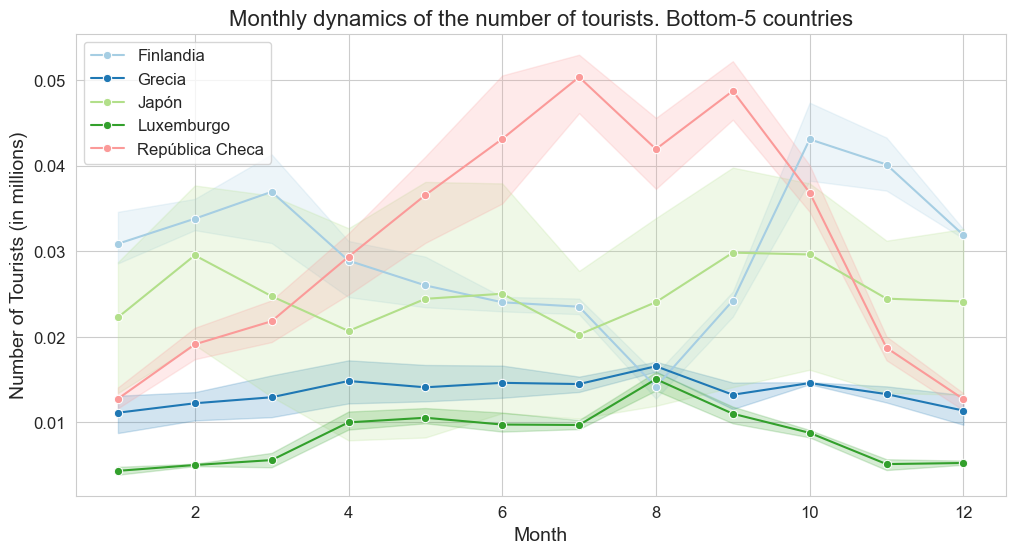

In [38]:
# bottom 5 countries by overall mean
bottom5_paises = df.groupby('Países')['total_travelers'].mean().nsmallest(5).index
df_bottom5 = df[df['Países'].isin(bottom5_paises)]

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_bottom5, x=df_bottom5['Periodo'].dt.month, y=df['total_travelers']/1000000, hue='Países', marker='o')

plt.title('Monthly dynamics of the number of tourists. Bottom-5 countries')
plt.xlabel('Month')
plt.ylabel('Number of Tourists (in millions)')
plt.legend(title=None)
plt.show()